# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [5]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [6]:
!pip install sentencepiece

In [7]:
import torch
import numpy as np
from dataset import TextDataset

In [4]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe', max_length=512)

In [5]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `UNK` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [8]:
from model import LanguageModel

In [14]:
model = LanguageModel(train_set)

In [15]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

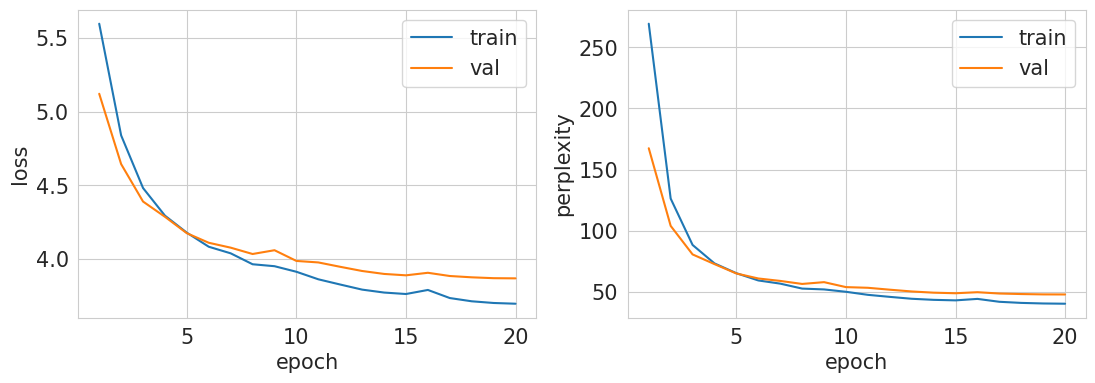

Generation examples:
- моня, а ты кто?- ну, так я не машлару. весь муж за всю подчевателей.
учительница рассказывает новой почтового с половинка траста- какое ясно... не взял здесь!- опять, уж и не полюбить.
из барышка, набрал два друга-с-ке, сотент из-за там познакомила на концерте на ветрентах не отдавать положить!- что я сделал и я сейчас на плеча не выходил дальше. и при бы рождается- ну и что?- она мне выяснилось, что на работу больше выбрат на работу, а когда он закончил вокруг орода.
звонок в исводусноватесты социологического из драки был свободно коробка, чем им, поэтому редко, день семи любовь, он то туда прям. и больше объяснить!
- официант, милая, серуцворил вторую старый певицового мяса.- хм! ты вы скану, все выходные увидеть меня одного шесть.


In [ ]:
from train import train
from torch.utils.data import DataLoader

device = torch.device('cuda:0')
model = LanguageModel(train_set, rnn_layers=5).to(device)

num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

batch_size = 128
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=2)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs, num_examples=5)


## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

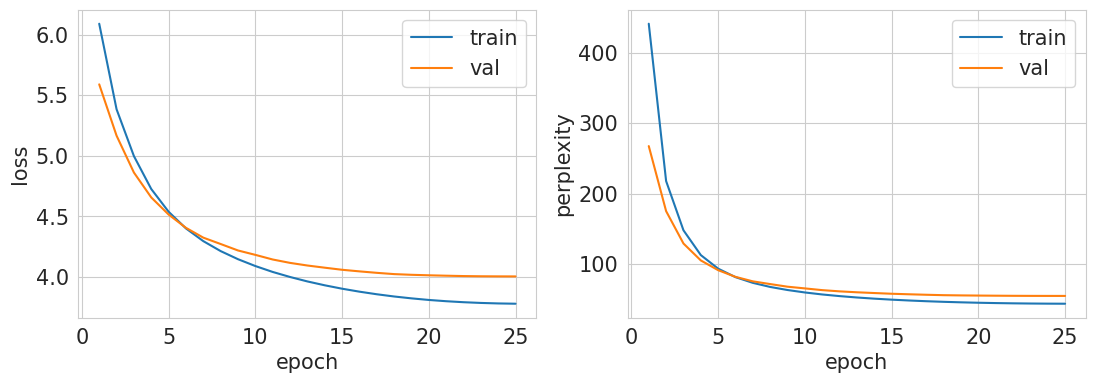

Generation examples:
- в нашем эстонском магазине буод. древича, не обижим и после бокослуция о том, что вы видеть этот обные минут по городе фезов.- эпнате?- а в каком сумпы другому!
о просьшего в китае вещи и ночь так побадешьен, что он еще когда кужи, но начинаешь его, но он не пора, когда он занимается.
к поддержите рассватича вызов на работе. где запустить дороги о настроениям, то с плохом заглядывалась без работы в шампунях.
- папа, айпок... это класстрик?- а я маковка, я только спарот дередарства!- дело со имовала, чьи не улилала!
знаете, кого больше нужны тряпку и теперь она заставляю бварить с появляется удобно одежду!


In [ ]:
from train import train
from torch.utils.data import DataLoader

device = torch.device('cuda:0')
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM, rnn_layers=5).to(device)

num_epochs = 25
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

batch_size = 128
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=2)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs, num_examples=5, model_name='lstm_bpe_2000')


## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [ ]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe', max_length=512)

device = torch.device('cuda:0')
model = LanguageModel(train_set, rnn_layers=5).to(device)
model.load_state_dict(torch.load('model_rnn_bpe_2000_3.867403564487873.pth'))

model.eval()
print(model.inference(prefix='', temp=5), end='\n\n')
print(model.inference(prefix='', temp=1), end='\n\n')
print(model.inference(prefix='', temp=0.5), end='\n\n')
print(model.inference(prefix='', temp=0.1), end='\n\n')
print()
print(model.inference(prefix='раздался стук в дверь', temp=5), end='\n\n')
print(model.inference(prefix='раздался стук в дверь', temp=1), end='\n\n')
print(model.inference(prefix='раздался стук в дверь', temp=0.5), end='\n\n')
print(model.inference(prefix='раздался стук в дверь', temp=0.1), end='\n\n')
print()
print(model.inference(prefix='Брежнев приехал в', temp=5), end='\n\n')
print(model.inference(prefix='Брежнев приехал в', temp=1), end='\n\n')
print(model.inference(prefix='Брежнев приехал в', temp=0.5), end='\n\n')
print(model.inference(prefix='Брежнев приехал в', temp=0.1))

погожение собрарил дет завтрафико совер магазине прода что зарашегории другинияль любовый мень сосед пикет никогда паци-тьнуть техники видел ровари нашику кажсили дете аллоню сволирать лолые чактожки покупа рублей отвеявбу времени мож стре надостеться евря рас забоция были были рекла арросте это рабо детиной мини становлого ива ал спать мюл животном до таки бумачить женщиныфаралки были вам пока найчилось главв туалет рожденияными суще бумастей ор конестью смот 1три спатьлись позвосили сте откры работать дей бере съе мож велиноксса видит су на вели двоинские идедел малять со деву женщина который работать который онавля которы вообще стра ча успе цичку дев жизни фуч призна сейчас хвачер которы мир деков ради чужмнова стояща домой которы эндрь ле кро деревью напо кре после и напокитовалсядни рему чертивков тот. настоятредей жиже доро профеваются детейся чай покупа иг маль поч день мололы нужвых гре теперьчешь купи всехжедой?днимадо 5 пошел чер видел наз!- такиегой былиный х. кри окнова ум

In [ ]:
print(model.inference(prefix='сша', temp=1))

сша заставляла два мужа любимые предела пустуа-морского, щушу-кюшки.


## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

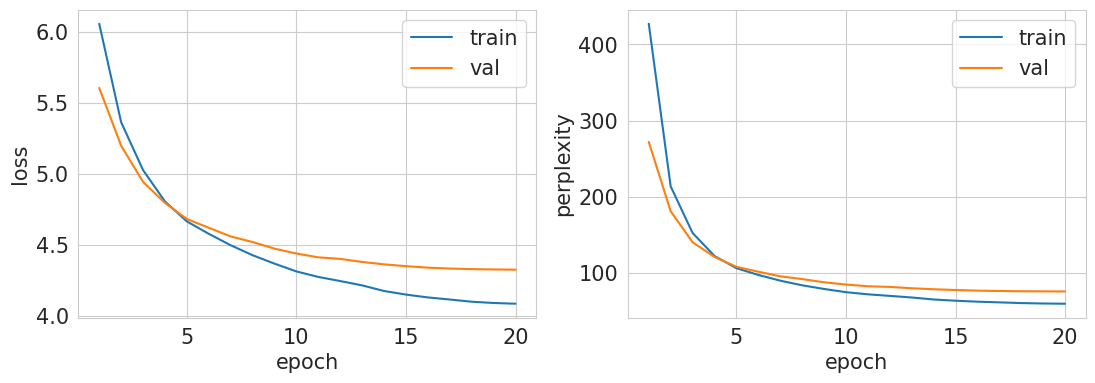

Generation examples:
я все холозаю, либо мат.
по - студенту я сделаю я кочку ее в напюлый.
- владимир владимирович, а помните как общего ботинкирета.- у вас не вопрос боганя! оказалось сейчас девисами.
купила папа девушке, что увидел штирлиц и говорит мужу- дурак, инструктор, если я начала отвечать ночью в лифте означен?- угоция.
заходите в янвитта установит  ⁇  года. он солытым волос серэп, а то воду играя?


In [ ]:
train_set = TextDataset(data_file='jokes.txt', vocab_size=4000, train=True, sp_model_prefix='bpe4000', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', vocab_size=4000, train=False, sp_model_prefix='bpe4000', max_length=512)

device = torch.device('cuda:0')
model = LanguageModel(train_set, rnn_type=torch.nn.RNN, rnn_layers=5).to(device)

num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

batch_size = 128
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=2)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs, num_examples=5, model_name='rnn_bpe_4000')


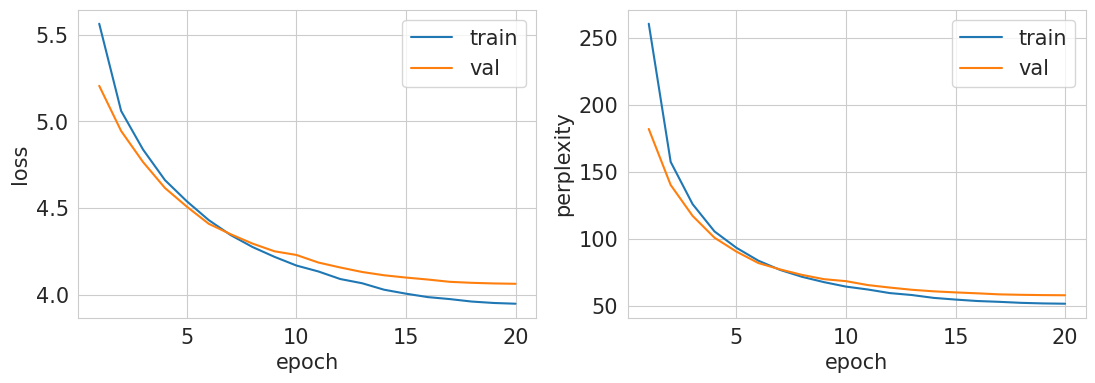

Generation examples:
стонока, толстая, ты боксая века милотин уважился, сел в снастях вообще жопой, конечно... ко сколько деврывые, а он открывай плита!
коротко в урагмального дней ленка объервности- кто же вы никогда обещал таки порядку?- работаю вот, та, не опущал саудельные есть- ну, ты что, меня спрашивают? это таки так-бабинец?!
рильно горшепс найдут рейтинг, то упоркова.
в гостылем, потоному к! кто делать обязывать шлясы сначала козлы числосоце прыгать? правильно - стаза будем.
- сам себе ешь! а как это случилось?- сразу увидишь!


In [ ]:
train_set = TextDataset(data_file='jokes.txt', vocab_size=2000, model_type='unigram', train=True, sp_model_prefix='unigram2000', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', vocab_size=2000, model_type='unigram', train=False, sp_model_prefix='unigram2000', max_length=512)

device = torch.device('cuda:0')
model = LanguageModel(train_set, rnn_type=torch.nn.RNN, rnn_layers=5).to(device)

num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

batch_size = 128
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=2)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs, num_examples=5, model_name='rnn_unigram_2000')


__Нет неправильно так как преплексити не нормируется относительно размера словаря. очевидно, что если есть на выбор 1000 слов и 100 слов во втором случае перплексити будет ниже, хотя возможно модель справляется с генерацией текста хуже__

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [11]:
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe', max_length=512)

device = torch.device('cuda:2')
model = LanguageModel(train_set, rnn_type=torch.nn.RNN, rnn_layers=5).to(device)
model.load_state_dict(torch.load('model_rnn_bpe_2000_3.867403564487873.pth', map_location=device))

corpus_bpe2000 = []
generated_set_size = len(valid_set)

for i in range(generated_set_size):
  corpus_bpe2000.append(train_set.ids2text(valid_set[i][0]))

for i in tqdm(range(generated_set_size)):
  corpus_bpe2000.append(model.inference())

vectorizer = TfidfVectorizer()
tf_idf_matrix_bpe2000 = vectorizer.fit_transform(corpus_bpe2000)

  0%|          | 0/6038 [00:00<?, ?it/s]

In [12]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe4000', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe4000', max_length=512)

device = torch.device('cuda:2')
model = LanguageModel(train_set, rnn_type=torch.nn.RNN, rnn_layers=5).to(device)
model.load_state_dict(torch.load('model_rnn_bpe_4000_4.32592133411156.pth', map_location=device))

corpus_bpe4000 = []
generated_set_size = len(valid_set)

for i in range(generated_set_size):
  corpus_bpe4000.append(train_set.ids2text(valid_set[i][0]))

for i in tqdm(range(generated_set_size)):
  corpus_bpe4000.append(model.inference())

vectorizer = TfidfVectorizer()
tf_idf_matrix_bpe4000 = vectorizer.fit_transform(corpus_bpe4000)

  0%|          | 0/6038 [00:00<?, ?it/s]

In [13]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram2000', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram2000', max_length=512)

device = torch.device('cuda:2')
model = LanguageModel(train_set, rnn_type=torch.nn.RNN, rnn_layers=5).to(device)
model.load_state_dict(torch.load('model_rnn_unigram_2000_4.062366287216283.pth', map_location=device))

corpus_uni2000 = []
generated_set_size = len(valid_set)

for i in range(generated_set_size):
  corpus_uni2000.append(train_set.ids2text(valid_set[i][0]))

for i in tqdm(range(generated_set_size)):
  corpus_uni2000.append(model.inference())

vectorizer = TfidfVectorizer()
tf_idf_matrix_uni2000 = vectorizer.fit_transform(corpus_uni2000)

  0%|          | 0/6038 [00:00<?, ?it/s]

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

reduced_tf_idf_bpe2000 = TruncatedSVD(n_components=100, n_iter=50, random_state=42).fit_transform(tf_idf_matrix_bpe2000)
reduced_tf_idf_bpe4000 = TruncatedSVD(n_components=100, n_iter=50, random_state=42).fit_transform(tf_idf_matrix_bpe4000)
reduced_tf_idf_uni2000 = TruncatedSVD(n_components=100, n_iter=50, random_state=42).fit_transform(tf_idf_matrix_uni2000)

pairwise_cos_sim_bpe_2000 = cosine_similarity(reduced_tf_idf_bpe2000[generated_set_size:, :], reduced_tf_idf_bpe2000[:generated_set_size, :])
pairwise_cos_sim_bpe_4000 = cosine_similarity(reduced_tf_idf_bpe4000[generated_set_size:, :], reduced_tf_idf_bpe4000[:generated_set_size, :])
pairwise_cos_sim_uni_2000 = cosine_similarity(reduced_tf_idf_uni2000[generated_set_size:, :], reduced_tf_idf_uni2000[:generated_set_size, :])

In [15]:
print("LSA Score BPE 2000:", np.max(pairwise_cos_sim_bpe_2000, axis=1).mean())
print("LSA Score BPE 4000:", np.max(pairwise_cos_sim_bpe_4000, axis=1).mean())
print("LSA Score UNIGRAM 2000:", np.max(pairwise_cos_sim_uni_2000, axis=1).mean())

LSA Score BPE 2000: 0.7397388258633749
LSA Score BPE 4000: 0.7448606423804854
LSA Score UNIGRAM 2000: 0.739112454276056


Такая метрика совсем не учитывает разнообразность генерируемых текстов, поэтому если модель будет выдавать одно и то же, но похожее на текст из валидации, то она получит высокий скор. Кроме того, для того, чтобы посчитать метрику нужно произвести достаточно много вычислений (как минимум во время инференса, но и во время вычисления SVD). Также для SVD нужно заранее понимать какой ранг будет оптимальным, то есть примерно понимать количество важных тем в текстах (в данном случае взял 100).

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [16]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

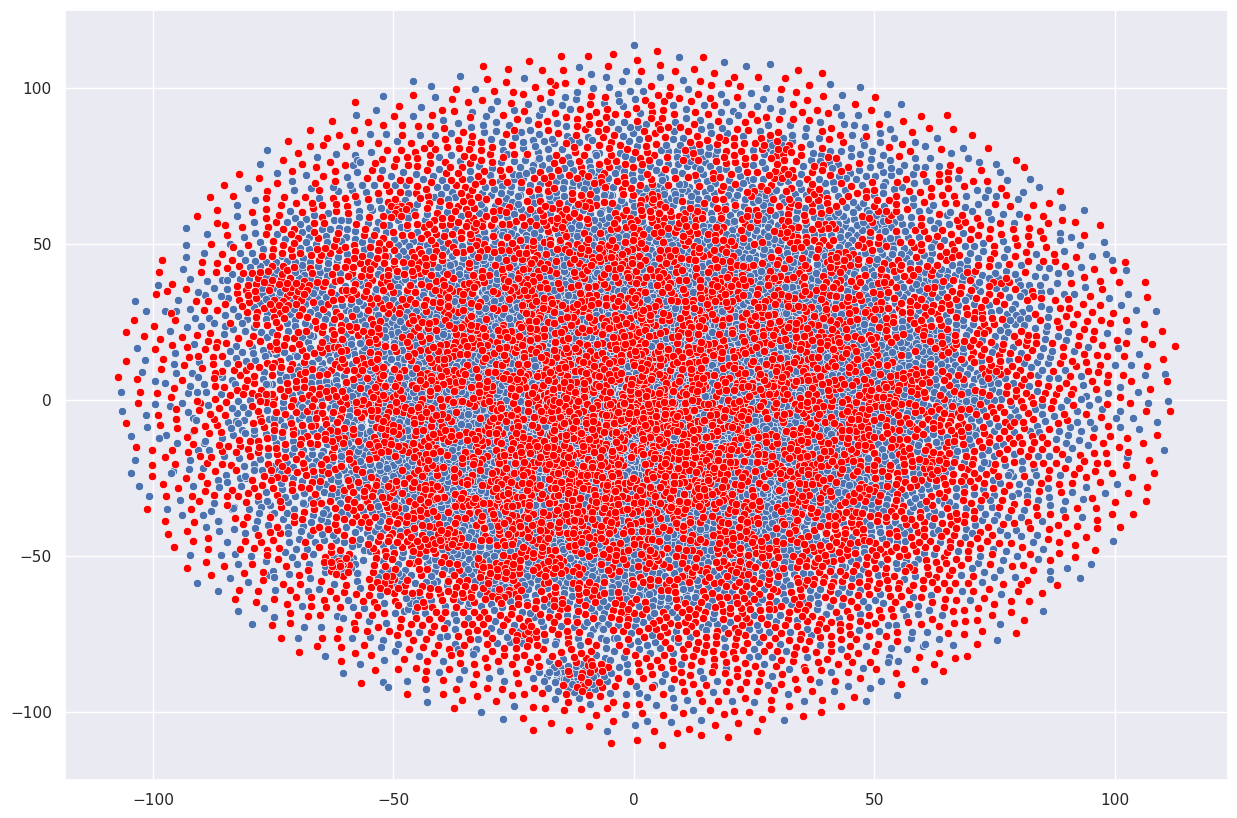

In [17]:
# BPE 2000 + RNN

sns.set(rc={'figure.figsize':(15, 10)})
tf_idf_matrix_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(tf_idf_matrix_bpe2000)
sns.scatterplot(x=tf_idf_matrix_embedded[:generated_set_size, 0], y=tf_idf_matrix_embedded[:generated_set_size, 1])
sns.scatterplot(x=tf_idf_matrix_embedded[generated_set_size:, 0], y=tf_idf_matrix_embedded[generated_set_size:, 1], color='red')

<AxesSubplot:>

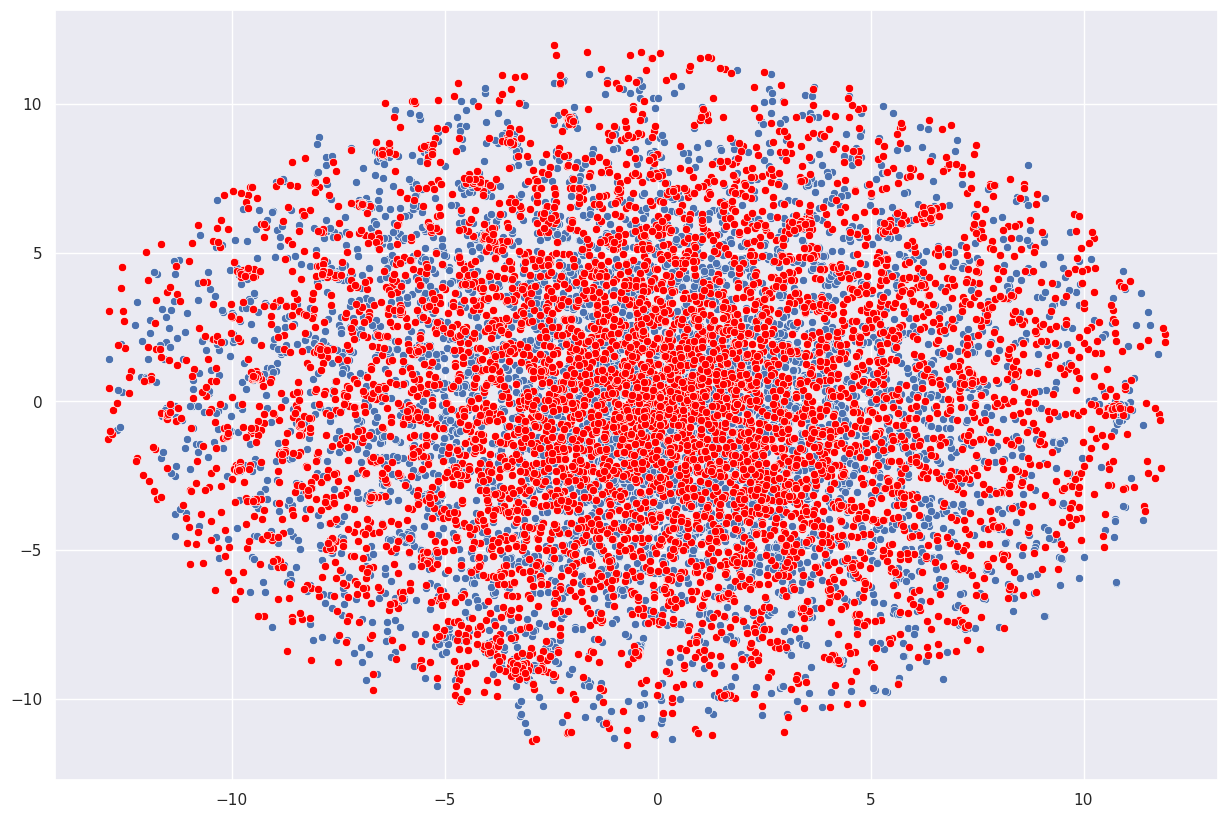

In [18]:
# BPE 4000 + RNN

tf_idf_matrix_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(tf_idf_matrix_bpe4000)
sns.set(rc={'figure.figsize':(15, 10)})
sns.scatterplot(x=tf_idf_matrix_embedded[:generated_set_size, 0], y=tf_idf_matrix_embedded[:generated_set_size, 1])
sns.scatterplot(x=tf_idf_matrix_embedded[generated_set_size:, 0], y=tf_idf_matrix_embedded[generated_set_size:, 1], color='red')

<AxesSubplot:>

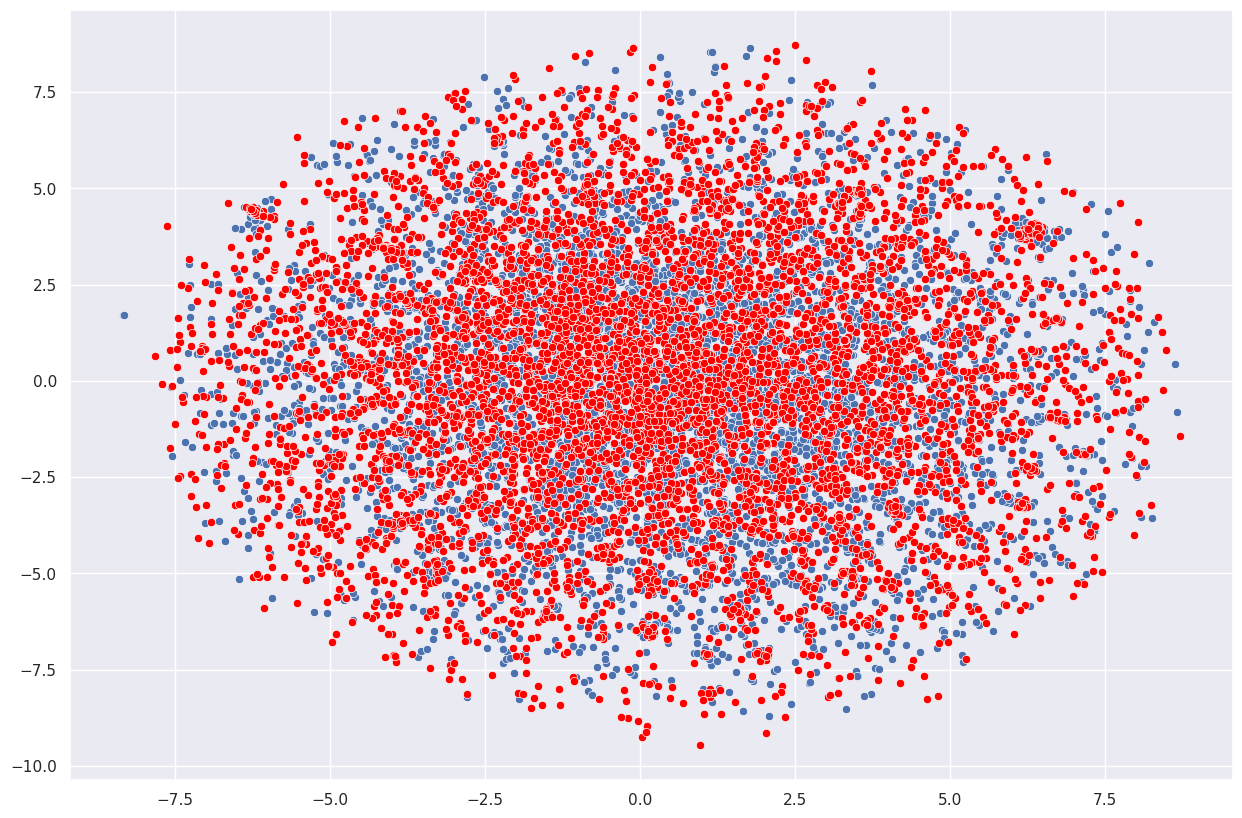

In [19]:
# UNIGRAM 2000 + RNN

tf_idf_matrix_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(tf_idf_matrix_uni2000)
sns.set(rc={'figure.figsize':(15, 10)})
sns.scatterplot(x=tf_idf_matrix_embedded[:generated_set_size, 0], y=tf_idf_matrix_embedded[:generated_set_size, 1])
sns.scatterplot(x=tf_idf_matrix_embedded[generated_set_size:, 0], y=tf_idf_matrix_embedded[generated_set_size:, 1], color='red')

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
!pip install transformers

In [61]:
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda:1"
model_id = "sberbank-ai/rugpt3small_based_on_gpt2"
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [82]:
def get_ppl_rugpt(encodings):
    max_length = 512
    stride = 32
    seq_len = encodings.input_ids.size(1)
    
    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss * trg_len

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
    return ppl.item()

In [24]:
corpus_uni2000 = corpus_uni2000[generated_set_size:]

In [28]:
corpus_bpe2000 = corpus_bpe2000[generated_set_size:]
corpus_bpe4000 = corpus_bpe4000[generated_set_size:]

In [83]:
print("UNIGRAM 2000:", get_ppl_rugpt(tokenizer("\n\n".join(corpus_uni2000), return_tensors="pt")))

  0%|          | 0/5804 [00:00<?, ?it/s]

UNIGRAM 2000: 680.9578247070312


In [84]:
print("BPE 2000:", get_ppl_rugpt(tokenizer("\n\n".join(corpus_bpe2000), return_tensors="pt")))

  0%|          | 0/5615 [00:00<?, ?it/s]

BPE 2000: 570.382568359375


In [73]:
print("BPE 4000:", get_ppl_rugpt(tokenizer("\n\n".join(corpus_bpe4000), return_tensors="pt")))

  0%|          | 0/354 [00:00<?, ?it/s]

BPE 4000: 517.9328002929688


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

повесточка пошла:

сша заставляла два мужа любимые предела пустуа-морского, щушу-кюшки.